In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Deep Learning**

###**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/abinaryclassification(naive bayes).csv")

In [ ]:
df.head()

,Tweet_id,Class,Sentence
0,1328,sadness,"#1: @idek ed ""My skin burns and is ugly. Make..."
1,1329,sadness,"#2: @🌹👻 ed ""@sad_adult Pardon my whining pls ..."
2,1330,sadness,"#3: @Kunjabihari panda ed ""@ANINewsUP This is..."
3,1331,sadness,"#4: @Ahmet UCAL ed ""RT @tgmcelebi: Bugün vata..."
4,1332,sadness,"#5: @☾ LILY ed ""RT @hoyaspop: I’m so sad.. ht..."


In [ ]:
df.drop(columns='Tweet_id', inplace=True)

In [ ]:
df.head()

,Class,Sentence
0,sadness,"#1: @idek ed ""My skin burns and is ugly. Make..."
1,sadness,"#2: @🌹👻 ed ""@sad_adult Pardon my whining pls ..."
2,sadness,"#3: @Kunjabihari panda ed ""@ANINewsUP This is..."
3,sadness,"#4: @Ahmet UCAL ed ""RT @tgmcelebi: Bugün vata..."
4,sadness,"#5: @☾ LILY ed ""RT @hoyaspop: I’m so sad.. ht..."


In [ ]:
df['Class'].value_counts()

Class
sadness      8014
happiness    7824
Name: count, dtype: int64

In [ ]:
print('Total Data : ', df['Sentence'].shape)
print('Total Label : ', df['Class'].shape)

Total Data :  (15839,)
Total Label :  (15839,)


In [ ]:
df['Class'].unique()

array(['sadness', 'happiness', nan], dtype=object)

In [ ]:
df.isnull().sum()

Class       1
Sentence    1
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

Class       0
Sentence    0
dtype: int64

In [ ]:
df['Class'].unique()

array(['sadness', 'happiness'], dtype=object)

###**Dataset Visualization**

####**Total Data and Label**

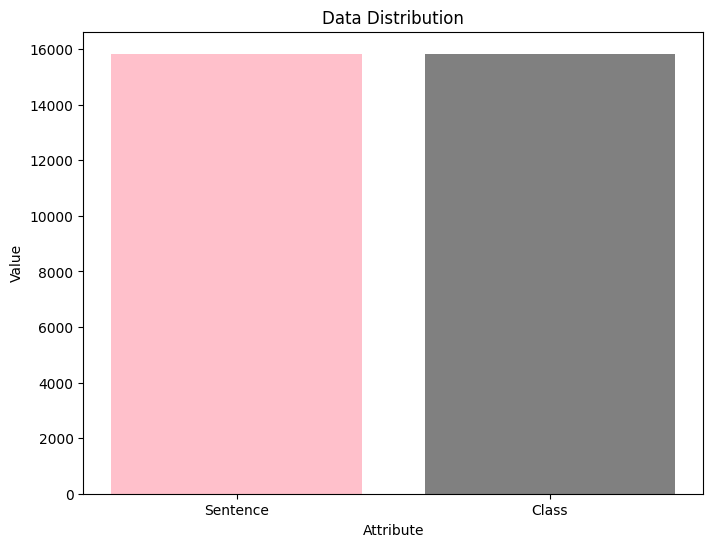

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(['Sentence', 'Class'], [df['Sentence'].shape[0], df['Class'].shape[0]], color = ['pink', 'grey'])
plt.title('Data Distribution')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.show()

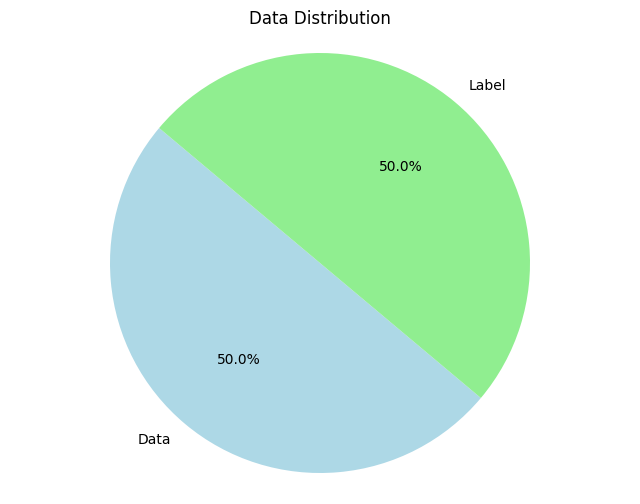

In [ ]:
plt.figure(figsize=(8, 6))
sizes = [df['Sentence'].shape[0], df['Class'].shape[0]]
labels = ['Data', 'Label']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors = ['lightblue', 'lightgreen'])
plt.axis('equal')
plt.title('Data Distribution')
plt.show()

####**Class Distribution of Target Variable**

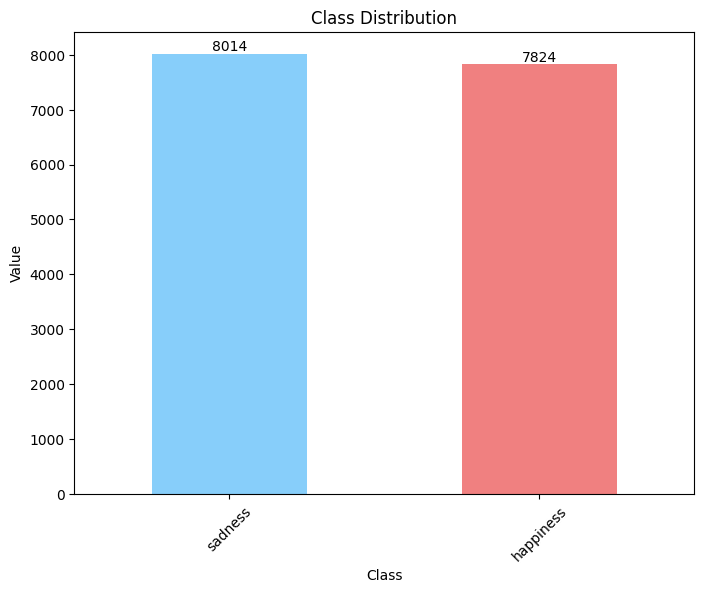

In [ ]:
import matplotlib.pyplot as plt

class_counts = df['Class'].value_counts()
colors = ['lightskyblue', 'lightcoral']

plt.figure(figsize=(8, 6))
bars = class_counts.plot(kind='bar', color=colors)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Value')
plt.xticks(rotation=45)

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


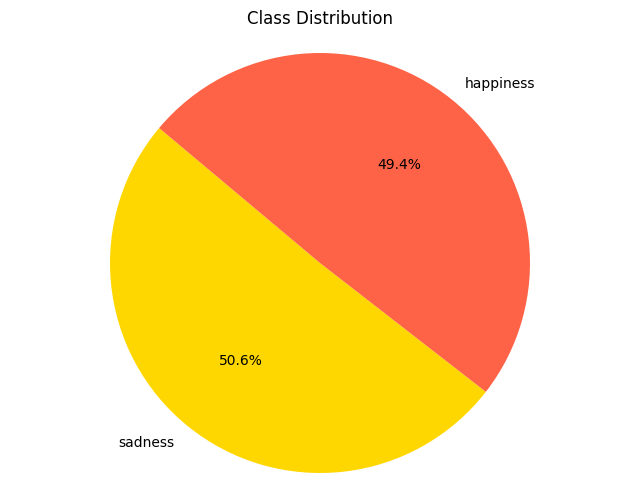

In [ ]:
plt.figure(figsize=(8, 6))
class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors = ['#FFD700', '#FF6347'])
plt.axis('equal')
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

###**Preprocessing**

1. Remove HTML tags
2. Remove URLs
3. Remove punctuation
4. Remove single-character words
5. Remove extra whitespaces
6. Remove digits
7. Remove Emoji

In [ ]:
import string
import re
def preprocess_text(text):
    if pd.isnull(text):
        return text
    text = text.lower()
    text = re.sub('<[^<]+?>', '', text)
    text = re.sub(r'http\S+', '', text)
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['Sentence'] = df['Sentence'].apply(preprocess_text)
print(df.head())

     Class                                           Sentence
0  sadness     idek ed my skin burns and is ugly makes me sad
1  sadness  🌹👻 ed sadadult pardon my whining pls thank for...
2  sadness  kunjabihari panda ed aninewsup this is called ...
3  sadness  ahmet ucal ed rt tgmcelebi bugün vatan için şe...
4  sadness                     lily ed rt hoyaspop i’m so sad


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['Sentence'] = df['Sentence'].apply(remove_emoji)
df.head()

,Class,Sentence
0,sadness,idek ed my skin burns and is ugly makes me sad
1,sadness,ed sadadult pardon my whining pls thank for l...
2,sadness,kunjabihari panda ed aninewsup this is called ...
3,sadness,ahmet ucal ed rt tgmcelebi bugün vatan için şe...
4,sadness,lily ed rt hoyaspop i’m so sad


###**Vocabulary Size and Max Sequence Length**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Sentence'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['Sentence']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 37296
Max sequence length: 101


###**Dependent and Independent Variable**

In [ ]:
X = df['Sentence']
y = df['Class']

###**Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

###**Data Split (80:20)**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12670,) (3168,) (12670,) (3168,)


###**Feature Extraction**

In [ ]:
# Keras Embedding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max_sequence_length
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_sequence_length, padding='post')

###**CNN Model**

In [ ]:
from keras.regularizers import l2
from keras.layers import Dropout, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='valid', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

custom_lr = 0.00001

optimizer = Adam(learning_rate=custom_lr)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Dataset/Depression/Model/best_model_using_normal_prep2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train_padded, y_train, epochs=200, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[model_checkpoint])

Epoch 1/200
198/198 [==============================] - ETA: 0s - loss: 2.1459 - accuracy: 0.4922
Epoch 1: val_accuracy improved from -inf to 0.49874, saving model to /content/drive/MyDrive/Dataset/Depression/Model/best_model_using_normal_prep2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 28s 132ms/step - loss: 2.1459 - accuracy: 0.4922 - val_loss: 2.1071 - val_accuracy: 0.4987
Epoch 2/200
198/198 [==============================] - ETA: 0s - loss: 2.0713 - accuracy: 0.5062
Epoch 2: val_accuracy improved from 0.49874 to 0.51768, saving model to /content/drive/MyDrive/Dataset/Depression/Model/best_model_using_normal_prep2.h5
198/198 [==============================] - 27s 138ms/step - loss: 2.0713 - accuracy: 0.5062 - val_loss: 2.0353 - val_accuracy: 0.5177
Epoch 3/200
198/198 [==============================] - ETA: 0s - loss: 2.0014 - accuracy: 0.5130
Epoch 3: val_accuracy improved from 0.51768 to 0.54198, saving model to /content/drive/MyDrive/Dataset/Depression/Model/best_model_using_normal_prep2.h5
198/198 [==============================] - 26s 129ms/step - loss: 2.0014 - accuracy: 0.5130 - val_loss: 1.9672 - val_accuracy: 0.5420
Epoch 4/200
198/198 [==============================] - ETA: 0s - loss: 1.9347 - accuracy: 0.5268
E

####**Loading Best Model**

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Depression Save Model/best_model_using_normal_prep2.h5')

####**Accuracy**

In [ ]:
loss, accuracy = model.evaluate(X_test_padded,y_test)
print('Loss of CNN Model : ',loss)
print('Accuracy of CNN Model : ',accuracy)

99/99 [==============================] - 3s 18ms/step - loss: 0.4781 - accuracy: 0.8497
Loss of CNN Model :  0.478059858083725
Accuracy of CNN Model :  0.8497474789619446


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_prob = model.predict(X_test_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print('Precision of CNN Model : ', precision)
print('Recall of CNN Model : ', recall)
print('F1-score of CNN Model : ', f1)

99/99 [==============================] - 1s 12ms/step
Precision of CNN Model :  0.8471100062150404
Recall of CNN Model :  0.8556183301946014
F1-score of CNN Model :  0.8513429106808245


####**Learning Curve**

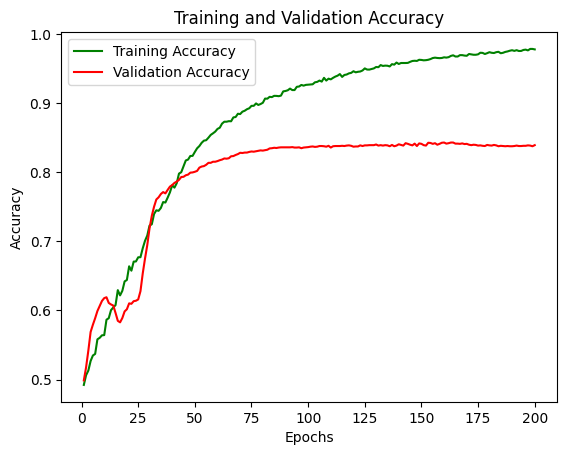

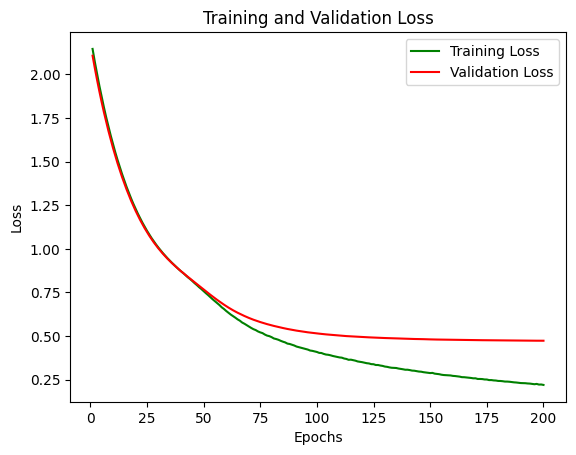

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)


plt.plot(epochs, training_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'g', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

####**Classification Report**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print(classification_report(y_test, y_pred, target_names=class_names))

99/99 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

       Happy       0.85      0.84      0.84      1575
         Sad       0.84      0.85      0.84      1593

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168



####**Confusion Matrix**

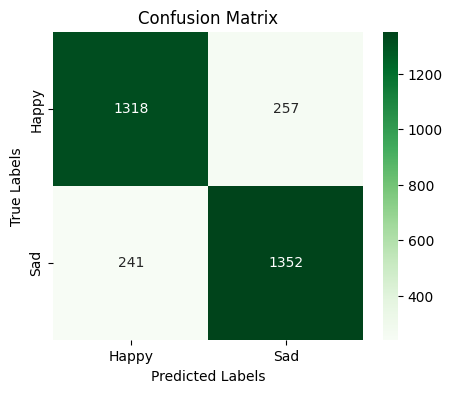

In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**ROC Curve**

99/99 [==============================] - 1s 8ms/step


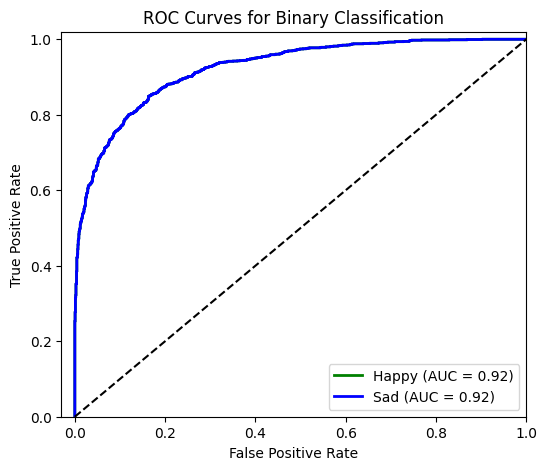

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_probs = model.predict(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classification')
plt.legend(loc='lower right')
plt.show()


####**AUC Curve**

99/99 [==============================] - 1s 2ms/step


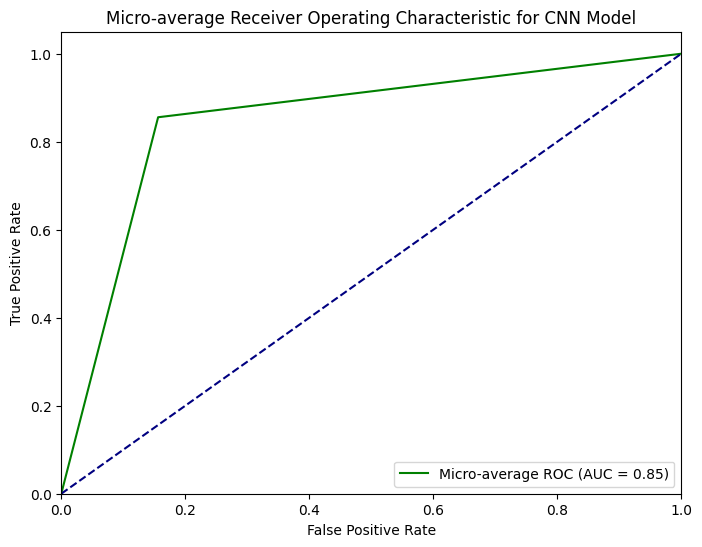

AUC = 0.8497139270020626


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

model = load_model('/content/drive/MyDrive/depress/best_model_using_normal_prep2.h5')

y_pred = model.predict(X_test_padded)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(np.round(y_pred), classes=np.unique(y_test))

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic for CNN Model')
plt.legend(loc="lower right")
plt.show()

print("AUC =", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


###**LSTM Model with Attention Layer**

In [ ]:
from keras.layers import Layer, LSTM, Dense, Embedding, Input
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)       #parameter jegula pass korbo oigula jate accept hoi seta

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)     # ekta biased create kora for attention mechanism jeta input sequence ta k represent kore

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)   #eita attention score gula compute kore
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1) # at hocche attention weights compute kore
        output = x * at          # input sequence er protita element k attention dewa
        return K.sum(output, axis=1) #final output compute kore

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1]) #sob gulo data same shape ey niye ase

embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(AttentionLayer())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Depression/best_model_lstm.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

optimizer = Adam(learning_rate=0.00005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 101, 128)          4775808   
                                                                 
 lstm (LSTM)                 (None, 101, 128)          131584    
                                                                 
 attention_layer (Attention  (None, 128)               229       
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4915942 (18.75 MB)
Trainable params: 4915942 (18.75 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), callbacks=[model_checkpoint])

Epoch 1/10
198/198 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5115
Epoch 1: val_accuracy improved from -inf to 0.50284, saving model to /content/drive/MyDrive/Depression/best_model_lstm.h5
198/198 [==============================] - 102s 491ms/step - loss: 0.6929 - accuracy: 0.5115 - val_loss: 0.6928 - val_accuracy: 0.5028
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5362
Epoch 2: val_accuracy did not improve from 0.50284
198/198 [==============================] - 97s 492ms/step - loss: 0.6919 - accuracy: 0.5362 - val_loss: 0.6907 - val_accuracy: 0.5028
Epoch 3/10
198/198 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.7192
Epoch 3: val_accuracy improved from 0.50284 to 0.77178, saving model to /content/drive/MyDrive/Depression/best_model_lstm.h5
198/198 [==============================] - 93s 472ms/step - loss: 0.5384 - accuracy: 0.7192 - val_loss: 0.4727 - val_accuracy: 0.7718
Epoch 4/10
198/198 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8488
Epoch 4: val_accuracy improved from 0.77178 to 0.80777, saving model to /content/drive/MyDrive/Depression/best_model_lstm.h5
198/198 [==============================] - 93s 468ms/step - loss: 0.3575 - accuracy: 0.8488 - val_loss: 0.4154 - val_accuracy: 0.8078
Epoch 5/10
198/198 [

####**Accuracy**

In [ ]:
model.load_weights('/content/drive/MyDrive/Depression Save Model/best_model_lstm.h5')

In [ ]:
loss, accuracy = model.evaluate(X_test_padded,y_test)
print('Loss of LSTM Model : ',loss)
print('Accuracy of LSTM Model : ',accuracy)

99/99 [==============================] - 5s 49ms/step - loss: 0.4479 - accuracy: 0.8273
Loss of LSTM Model :  0.44785505533218384
Accuracy of LSTM Model :  0.8273358345031738


In [ ]:
loss, accuracy = model.evaluate(X_test_padded,y_test)
print('Loss of LSTM Model : ',loss)
print('Accuracy of LSTM Model : ',accuracy)

99/99 [==============================] - 4s 41ms/step - loss: 0.4479 - accuracy: 0.8273
Loss of LSTM Model :  0.44785505533218384
Accuracy of LSTM Model :  0.8273358345031738


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_prob = model.predict(X_test_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print('Precision of LSTM Model : ', precision)
print('Recall of LSTM Model : ', recall)
print('F1-score of LSTM Model : ', f1)

99/99 [==============================] - 5s 55ms/step
Precision of LSTM Model :  0.8495989304812834
Recall of LSTM Model :  0.7978656622724419
F1-score of LSTM Model :  0.8229200388475234


####**Learning Curve**

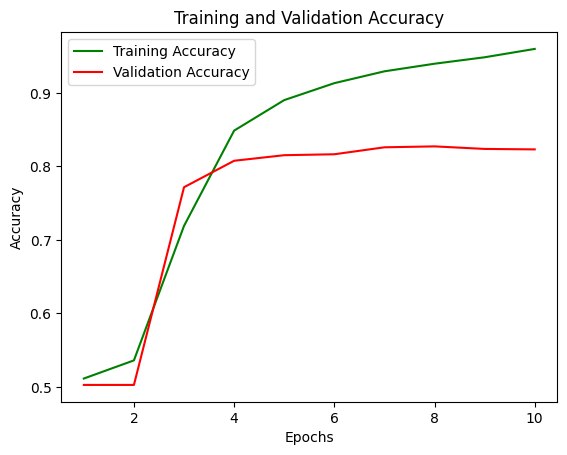

In [ ]:
import matplotlib.pyplot as plt

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)

plt.plot(epochs, training_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

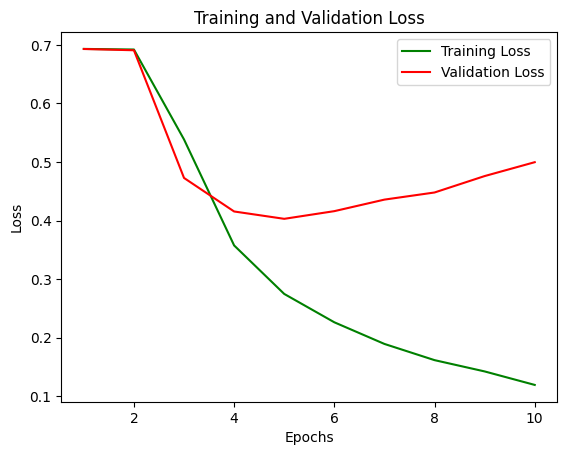

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'g', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('\n')

####**Classification Report**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

class_names = ["Happy", "Sad"]
print('Classification_reports')
print(classification_report(y_test, y_pred, target_names=class_names))

99/99 [==============================] - 6s 62ms/step
Classification_reports
              precision    recall  f1-score   support

       Happy       0.81      0.86      0.83      1575
         Sad       0.85      0.80      0.82      1593

    accuracy                           0.83      3168
   macro avg       0.83      0.83      0.83      3168
weighted avg       0.83      0.83      0.83      3168



####**Confusion Matrix**

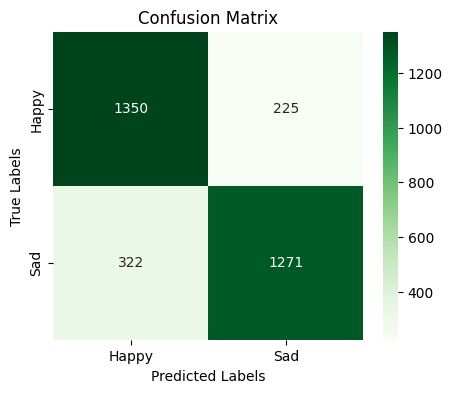

In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

####**ROC Curve**

99/99 [==============================] - 5s 49ms/step


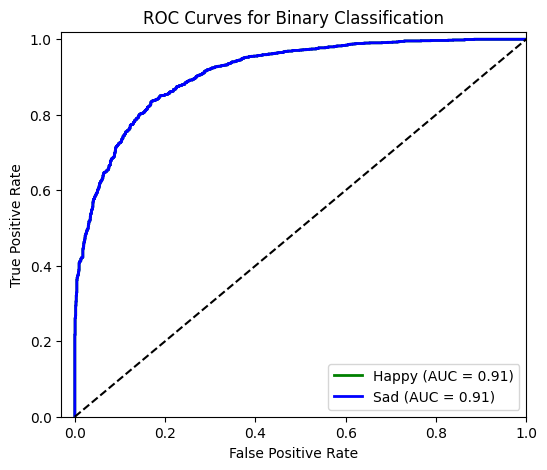

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_probs = model.predict(X_test_padded)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
plt.plot(fpr[0], tpr[0], color='green', lw=2, label=f'Happy (AUC = {roc_auc[0]:.2f})')
plt.plot(fpr[1], tpr[1], color='blue', lw=2, label=f'Sad (AUC = {roc_auc[1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classification')
plt.legend(loc='lower right')
plt.show()

####**AUC Curve**

99/99 [==============================] - 5s 45ms/step


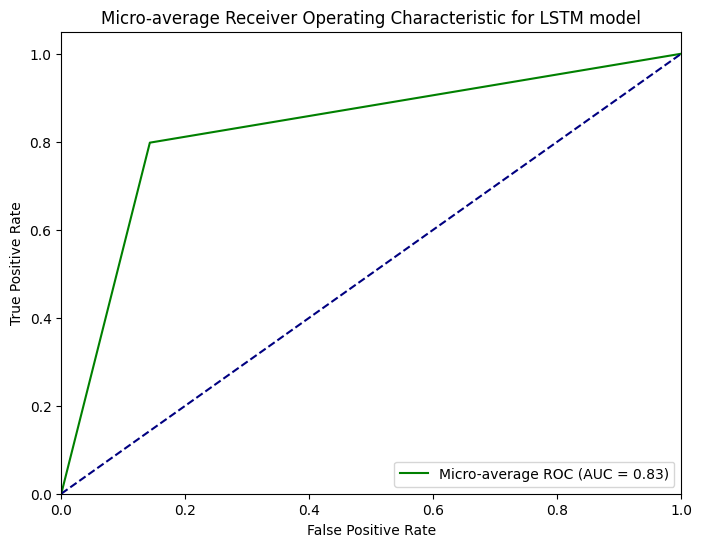

AUC = 0.8275042597076497


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/depress/best_model_lstm.h5', custom_objects={'AttentionLayer': AttentionLayer})

y_pred = model.predict(X_test_padded)

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
predictions_bin = label_binarize(np.round(y_pred), classes=np.unique(y_test))

fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), predictions_bin.ravel())

roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic for LSTM model')
plt.legend(loc="lower right")
plt.show()

print("AUC =", roc_auc_score(y_test_bin.ravel(), predictions_bin.ravel()))


##**Results Visualization**

### Machine learning

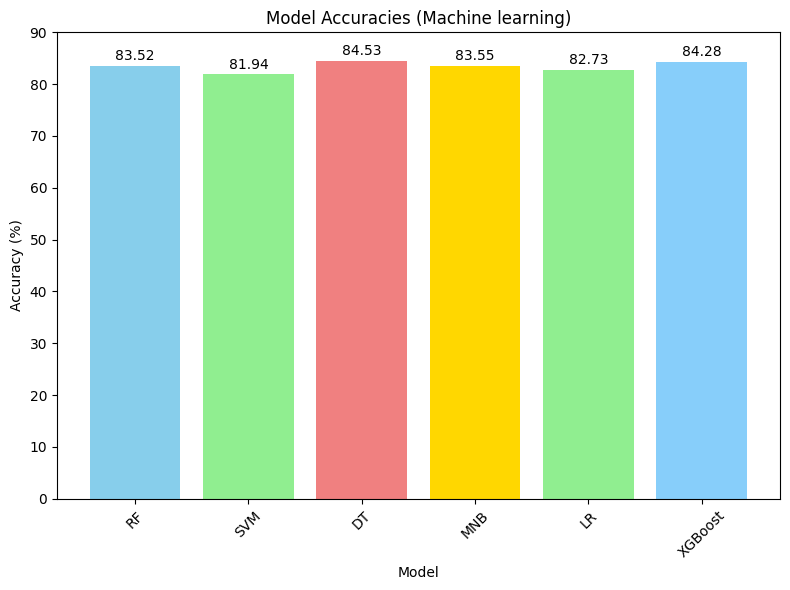

In [ ]:
import matplotlib.pyplot as plt

models = ['RF', 'SVM', 'DT', 'MNB','LR','XGBoost']
accuracies = [83.52, 81.94, 84.53, 83.55, 82.73, 84.28]

colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold','lightgreen', 'lightskyblue', 'lightpink', 'lightgrey']

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracies (Machine learning)')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(acc),
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 90)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Ensemble learning

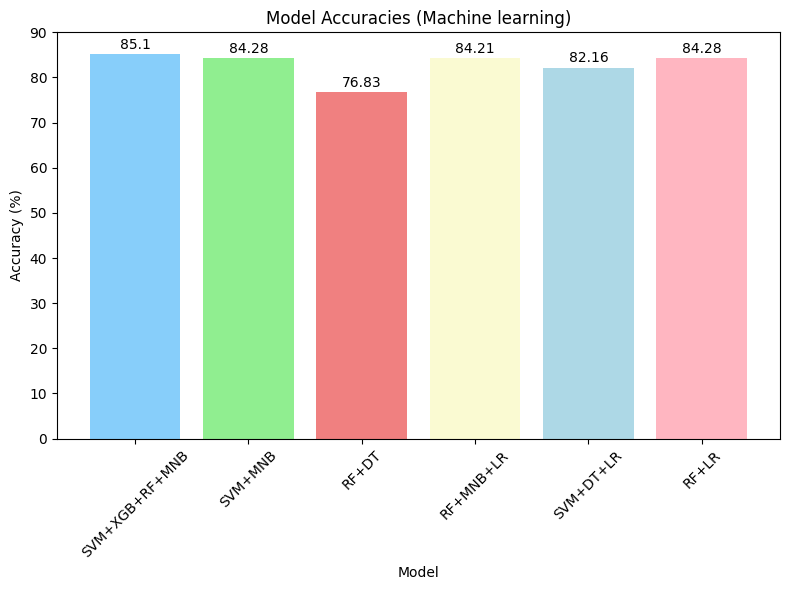

In [ ]:
import matplotlib.pyplot as plt

models = ['SVM+XGB+RF+MNB', 'SVM+MNB', 'RF+DT', 'RF+MNB+LR','SVM+DT+LR','RF+LR']
accuracies = [85.10, 84.28, 76.83, 84.21, 82.16, 84.28]

colors = ['lightskyblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow', 'lightblue', 'lightpink']

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracies (Ensemble learning)')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(acc),
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 90)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Deep learning

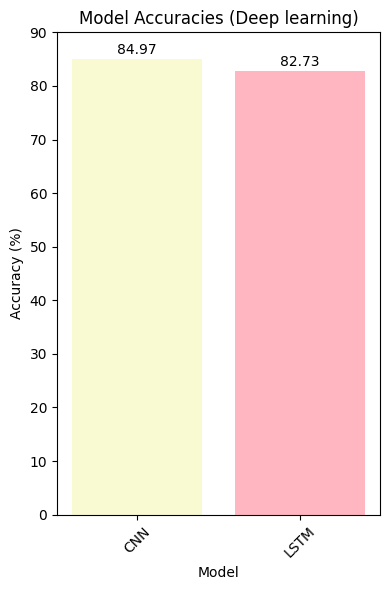

In [ ]:
import matplotlib.pyplot as plt

models = ['CNN', 'LSTM']
accuracies = [ 84.97, 82.73]

colors = ['lightgoldenrodyellow', 'lightpink']

plt.figure(figsize=(4, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracies (Deep learning)')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(acc),
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 90)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
